# Example of using btrack to track cells in timelapse microscopy data

This notebook covers the following functionality:

* Load segmentation data and localize objects
* Load a table of localized objects 
* Run tracking algorithm
* Inspect the output
* Visualize the results in napari

In addition, we have an extensive tutorial of the cell tracking application as part of *napari*:  

https://napari.org/tutorials/tracking/cell_tracking.html

## Importing btrack and loading example datasets

In [1]:
import btrack

from btrack import datasets

We can automatically download some example data to play with:

In [2]:
CONFIG_FILE = datasets.cell_config()
SEGMENTATION_FILE = datasets.example_segmentation_file()
OBJECTS_FILE = datasets.example_track_objects_file()

## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread

In [4]:
segmentation = imread(SEGMENTATION_FILE)

In [5]:
segmentation.shape

(500, 1200, 1600)

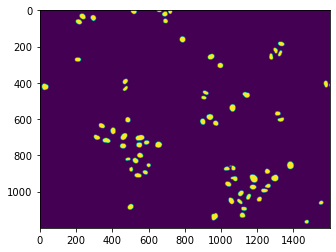

In [6]:
plt.imshow(segmentation[0, ...])

### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [7]:
objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=('area', ), 
)

We can also inspect each returned object to determine it's properties:

In [8]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area
0,0,517.573657,9.07279,0.0,0,False,0,5,0.0,577


### Use case 2 - from a table of objects

We can also load objects from a simple CSV file, that may contain additional information such as a state label.

In [9]:
objects = btrack.dataio.import_CSV(OBJECTS_FILE)

In [10]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob
0,0,517.559509,9.081633,0.0,0,False,0,0,0.0


## Running the tracking

In [11]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(CONFIG_FILE)
    tracker.max_search_radius = 50

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[WARNING][2022/04/05 11:49:49 AM] btrack (v0.4.3) shared library mismatch.
[INFO][2022/04/05 11:49:49 AM] Setting max XYZ search radius to: 100
[INFO][2022/04/05 11:49:49 AM] Starting BayesianTracker session
[INFO][2022/04/05 11:49:49 AM] Loading motion model: cell_motion
[INFO][2022/04/05 11:49:49 AM] Setting max XYZ search radius to: 50
[INFO][2022/04/05 11:49:49 AM] Set volume to ((0, 1600), (0, 1200), (-100000.0, 100000.0))
[INFO][2022/04/05 11:49:49 AM] Starting tracking... 
[INFO][2022/04/05 11:49:49 AM] Tracking objects in frames 0 to 99 (of 500)...
[INFO][2022/04/05 11:49:50 AM] Tracking objects in frames 100 to 199 (of 500)...


Instantiating BTRACK interface wrapper (v0.4.3, compiled Nov 25 2021 at 11:31:42)


[INFO][2022/04/05 11:49:50 AM] Tracking objects in frames 200 to 299 (of 500)...
[INFO][2022/04/05 11:49:50 AM] Tracking objects in frames 300 to 399 (of 500)...
[INFO][2022/04/05 11:49:50 AM] Tracking objects in frames 400 to 499 (of 500)...
[INFO][2022/04/05 11:49:51 AM] SUCCESS.
[INFO][2022/04/05 11:49:51 AM]  - Found 507 tracks in 500 frames (in 0.0s)
[INFO][2022/04/05 11:49:51 AM]  - Inserted 97 dummy objects to fill tracking gaps
[INFO][2022/04/05 11:49:51 AM] Loading hypothesis model: cell_hypothesis
[INFO][2022/04/05 11:49:51 AM] Calculating hypotheses (relax: True)...
[INFO][2022/04/05 11:49:51 AM]  - Fates.FALSE_POSITIVE: 32 (of 507)
[INFO][2022/04/05 11:49:51 AM]  - Fates.LINK: 98 (of 348)
[INFO][2022/04/05 11:49:51 AM]  - Fates.DIVIDE: 110 (of 121)
[INFO][2022/04/05 11:49:51 AM]  - Fates.APOPTOSIS: 1 (of 2)
[INFO][2022/04/05 11:49:51 AM]  - Fates.INITIALIZE_BORDER: 53 (of 97)
[INFO][2022/04/05 11:49:51 AM]  - Fates.INITIALIZE_FRONT: 70 (of 72)
[INFO][2022/04/05 11:49:51 AM]

GLPK Integer Optimizer, v4.65
2028 rows, 1992 columns, 3089 non-zeros
1992 integer variables, all of which are binary
Preprocessing...
1014 rows, 1992 columns, 3089 non-zeros
1992 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1014
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
1014 rows, 1992 columns, 3089 non-zeros
*     0: obj =   4.053900533e+03 inf =   0.000e+00 (365)
*   343: obj =   8.200734509e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   343: mip =     not found yet >=              -inf        (1; 0)
+   343: >>>>>   8.200734509e+02 >=   8.200734509e+02   0.0% (1; 0)
+   343: mip =   8.200734509e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Deleting BTRACK interface wrapper


## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [12]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy
0,1,0,517.559509,9.081633,0.0,1,1,0,0,False
1,1,1,514.647217,5.522222,0.0,1,1,2,0,False


Finally, we an inspect the entire tracking output using *napari*:

In [13]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
)

<Tracks layer 'Tracks' at 0x17ffc5940>